Сформировать с помощью sklearn.make_classification датасет из 100 объектов с двумя признаками, обучить случайный лес из 1, 3, 10 и 50 деревьев и визуализировать их разделяющие гиперплоскости на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции predict на tree_vote).

In [816]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import random
from collections import Counter, defaultdict


from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

In [817]:
classification_data, classification_labels = datasets.make_classification(n_samples=100,
                                                      n_features = 2, n_informative = 2, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=23)

In [818]:
random.seed(42)

def get_bootstrap(data, labels, N):
    n_samples = data.shape[0]
    bootstrap = []
    
    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        samples = []       
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
            samples.append(sample_index)
        bootstrap.append((b_data, b_labels, samples))
        
    return bootstrap

In [819]:
def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = [i for i in range(len_sample)]
    
    len_subsample = int(np.sqrt(len_sample))
    subsample = []
    
    random.shuffle(sample_indexes)
    subsample = sample_indexes[0:len_subsample].copy()
#     for _ in range(len_subsample):
#         subsample.append(sample_indexes.pop())
        
    return subsample

In [820]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [821]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        

In [822]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    # выбор индекса из подвыборки длиной sqrt(n_features)
    subsample = get_subsample(n_features)
    
    for index in subsample:
        t_values = [row[index] for row in data]
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [823]:
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels, samples in bootstrap:
        forest.append((build_tree(b_data, b_labels), samples))
    
#     tree_vote(forest, data, oob_ = True)
        
    return forest

In [824]:
# Функция классификации отдельного объекта

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

# функция формирования предсказания по выборке на одном дереве

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

# предсказание голосованием деревьев

def tree_vote(forest, data, oob_ = False):

    # добавим предсказания всех деревьев в список
    predictions = []
#     predictions_oob = [[]]*data.shape[0]
    
    for tree, samples in forest:
        predictions.append(predict(data, tree))

    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    
    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
#         print(type(obj))
    

    return voted_predictions

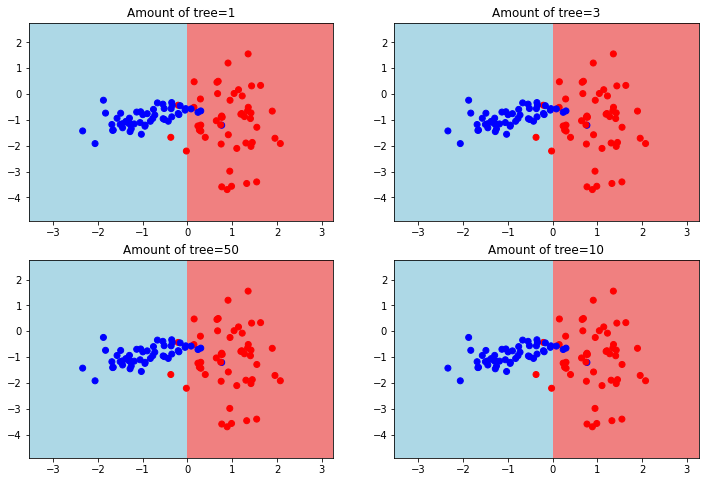

In [825]:
def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

def make_tree_scatter(ax,n,data = classification_data,labels = classification_labels):
    my_forest_1 = random_forest(classification_data, classification_labels, n)
    ax.set_title(f'Amount of tree={n}')
    colors = ListedColormap(['red', 'blue'])
    light_colors = ListedColormap(['lightcoral', 'lightblue'])
    light_colors = ListedColormap(['lightcoral', 'lightblue'])
    xx, yy = get_meshgrid(classification_data)
    mesh_predictions_1 = np.array(tree_vote(my_forest_1,np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    ax.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    ax.scatter(classification_data[:, 0], [classification_data[:, 1]], c = classification_labels, cmap = colors)

fig, ax= plt.subplots(nrows = 2, ncols = 2)
ax1, ax2, ax3, ax4 = ax.flatten()
fig.set_size_inches(12,8)
make_tree_scatter(ax1,1)
make_tree_scatter(ax2,3)
make_tree_scatter(ax4,10)
make_tree_scatter(ax3,50)

Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем.

In [826]:
# Количество деревьев практически не влияет на переобучение

3*. Заменить в реализованном алгоритме проверку с помощью отложенной выборки на Out-of-Bag

In [827]:
def oob_prediction(forest, data,labels):
    predictions_oob =defaultdict(list)
    labels_oob = defaultdict(list)
    for i in range(data.shape[0]):
        temp =[]
        for tree, samples in forest:
            if i not in samples:
                predictions_oob[i].append(*predict(data[i].reshape(1,2), tree))
                labels_oob[i].append(labels[i])
   
    voted_predictions = {}
    
    for index, value in predictions_oob.items():
        voted_predictions[index]=max(set(value), key=value.count)
        
        actual =[] 
        predicted =[]
    
    for i in voted_predictions.keys():
        actual.append(labels[i]) 
        predicted.append(voted_predictions[i]) 
        
    return  actual, predicted

In [828]:
n_trees = 100
forest_1 = random_forest(classification_data, classification_labels, n_trees)

In [829]:
actual, predicted =oob_prediction(forest_1, classification_data, classification_labels)


In [830]:
# Введем функцию подсчета точности как доли правильных ответов

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [831]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(actual, predicted)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

Точность случайного леса из 100 деревьев на обучающей выборке: 94.000


4*. (На повторение) Переписать функцию calc_gini из урока про решающие деревья так, чтобы в качестве критерия использовалась энтропия Шэннона. Переименовать функцию в calc_entropy.

In [832]:
def entropy(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 0
    for label in classes:
        p = classes[label] / len(labels)
        if p==0:
            return 0
        impurity -= p*np.log2(p)
        
    return impurity, classes